In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
#Extracting DataFrame From Web :
import pandas_datareader as web

c:\python38\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
#Stock Symbol Used : Alphabet A Inc - > Google 
# From 1 April 2020 to 30 June 2020
#This data is full collection of all stock features from Google's Stock Market
df_g=web.DataReader('GOOGL',data_source='yahoo',start='04-01-2008',end='07-15-2020')

In [4]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3096 entries, 2008-03-31 to 2020-07-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3096 non-null   float64
 1   Low        3096 non-null   float64
 2   Open       3096 non-null   float64
 3   Close      3096 non-null   float64
 4   Volume     3096 non-null   float64
 5   Adj Close  3096 non-null   float64
dtypes: float64(6)
memory usage: 169.3 KB


In [5]:
df_g.describe()

,High,Low,Open,Close,Volume,Adj Close
count,3096.000000,3096.000000,3096.000000,3096.000000,3.096000e+03,3096.000000
mean,626.868329,615.222647,621.217717,621.242207,4.146254e+06,621.242207
std,372.709700,365.852748,369.251015,369.532703,3.653904e+06,369.532703
min,134.819824,123.773773,131.386383,128.848846,5.206000e+05,128.848846
25%,294.304291,288.896393,292.038300,291.197449,1.658425e+06,291.197449
50%,548.340027,540.234985,544.587341,544.230011,3.046400e+06,544.230011
75%,949.925018,936.864990,943.889999,943.267502,5.291950e+06,943.267502
max,1576.359985,1520.979980,1549.939941,1539.010010,3.643470e+07,1539.010010


In [6]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
df_g
#Indicating Number Of days and features -> 123 days and 6 stock features

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-03-31,221.566574,216.221222,218.038040,220.455460,8883900.0,220.455460
2008-04-01,233.483490,223.658661,224.094101,233.088089,12174000.0,233.088089
2008-04-02,238.108109,230.425430,235.185181,233.083084,11986000.0,233.083084
2008-04-03,231.876877,224.289291,231.096100,227.787781,13543200.0,227.787781
2008-04-04,239.154160,228.328323,228.733734,235.780777,11782600.0,235.780777
...,...,...,...,...,...,...
2020-07-09,1529.140015,1495.589966,1509.930054,1518.660034,2091800.0,1518.660034
2020-07-10,1541.339966,1500.719971,1513.250000,1539.010010,1795900.0,1539.010010
2020-07-13,1576.359985,1506.560059,1549.939941,1512.229980,2147700.0,1512.229980


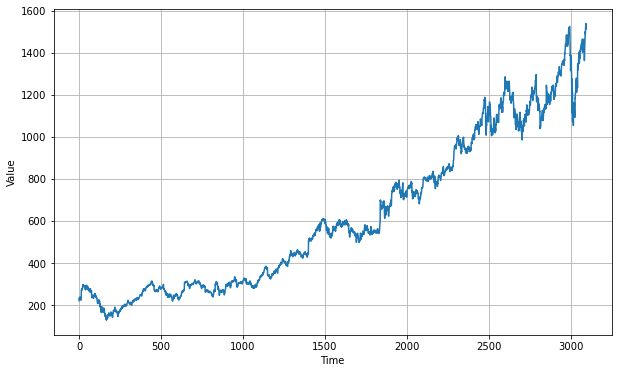

In [8]:

temps=[]
time_step=[]

step=0
for row in range(3096):
      time_step.append(step)
      step = step + 1

ds = np.array(df_g['Close'].values)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, ds)



In [9]:
ds_g = ds.reshape(-1,1)
print(ds_g.shape)

(3096, 1)


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
series = scaler.fit_transform(ds_g)

In [11]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def windowed_valid_dataset(series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [15]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [16]:
print(train_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [17]:
#Checking The Batches And their corresponding or respective label ,x and y 
for x,y in train_set:
    print("x :",x.numpy())
    print("y :",y.numpy())

x : [[[0.10262992]
  [0.09744448]
  [0.09577278]
  [0.09816143]
  [0.09966986]
  [0.09636196]
  [0.12073815]
  [0.11978696]
  [0.12248793]
  [0.11993247]
  [0.1240638 ]
  [0.12805316]
  [0.12831935]
  [0.12957577]
  [0.12414543]
  [0.12546576]
  [0.12289256]
  [0.12398572]
  [0.11888545]
  [0.12199815]
  [0.11360417]
  [0.11414367]
  [0.10242407]
  [0.11214545]
  [0.10348529]
  [0.10814189]
  [0.10872398]
  [0.10640276]
  [0.0999325 ]
  [0.09785618]]

 [[0.08610109]
  [0.08803898]
  [0.08969293]
  [0.08548707]
  [0.08271867]
  [0.08076658]
  [0.08130962]
  [0.08275061]
  [0.08006028]
  [0.0769192 ]
  [0.07493872]
  [0.07678433]
  [0.07306117]
  [0.07375683]
  [0.07345869]
  [0.06843651]
  [0.06630342]
  [0.05767875]
  [0.0572209 ]
  [0.05562375]
  [0.06257671]
  [0.06396446]
  [0.06261575]
  [0.06583492]
  [0.05574087]
  [0.06446846]
  [0.06804255]
  [0.06129543]
  [0.06098665]
  [0.0630594 ]]

 [[0.13586858]
  [0.13567337]
  [0.13663167]
  [0.13787391]
  [0.14479847]
  [0.14581712]
  

  [0.12453941]]]
y : [[[0.09695112]]

 [[0.11450923]]

 [[0.11448439]]

 [[0.08124572]]

 [[0.0982537 ]]

 [[0.08450039]]

 [[0.01917301]]

 [[0.1038899 ]]

 [[0.08461751]]

 [[0.10864235]]

 [[0.08556871]]

 [[0.08995202]]

 [[0.08324395]]

 [[0.13157401]]

 [[0.06183137]]

 [[0.09760419]]

 [[0.12806026]]

 [[0.14900078]]

 [[0.11862281]]

 [[0.03237975]]

 [[0.10378342]]

 [[0.1592581 ]]

 [[0.09853764]]

 [[0.11525103]]

 [[0.08807802]]

 [[0.03737708]]

 [[0.10145868]]

 [[0.05400884]]

 [[0.12275059]]

 [[0.12028031]]

 [[0.12754206]]

 [[0.12596264]]]
x : [[[0.06257671]
  [0.06396446]
  [0.06261575]
  [0.06583492]
  [0.05574087]
  [0.06446846]
  [0.06804255]
  [0.06129543]
  [0.06098665]
  [0.0630594 ]
  [0.06465302]
  [0.06161486]
  [0.04385445]
  [0.05078258]
  [0.05475773]
  [0.04722269]
  [0.04595206]
  [0.04037974]
  [0.03143565]
  [0.02863175]
  [0.02539128]
  [0.02646316]
  [0.04386155]
  [0.03736288]
  [0.02900797]
  [0.03392367]
  [0.04085179]
  [0.04325818]
  [0.037377

x : [[[0.11698661]
  [0.11768581]
  [0.11856603]
  [0.11821464]
  [0.12006736]
  [0.11914809]
  [0.12078784]
  [0.11943204]
  [0.12031225]
  [0.12111438]
  [0.1219804 ]
  [0.1257284 ]
  [0.12814189]
  [0.12969999]
  [0.12846841]
  [0.1296503 ]
  [0.12867426]
  [0.13107711]
  [0.13009752]
  [0.12451456]
  [0.11948883]
  [0.12229982]
  [0.12197685]
  [0.11820399]
  [0.1170008 ]
  [0.11798039]
  [0.11448439]
  [0.11718891]
  [0.1146299 ]
  [0.11554206]]

 [[0.09562371]
  [0.09996089]
  [0.10053586]
  [0.10062816]
  [0.09762548]
  [0.09490676]
  [0.09396267]
  [0.09816852]
  [0.0984986 ]
  [0.09491031]
  [0.09678076]
  [0.09656781]
  [0.09747287]
  [0.10119602]
  [0.10265832]
  [0.10265477]
  [0.10264057]
  [0.10000348]
  [0.09342317]
  [0.09514456]
  [0.09740898]
  [0.10005317]
  [0.09632647]
  [0.09585086]
  [0.0914285 ]
  [0.08450039]
  [0.0867648 ]
  [0.08775859]
  [0.09131138]
  [0.0914569 ]]

 [[0.1235314 ]
  [0.12308421]
  [0.12242759]
  [0.12119956]
  [0.12193781]
  [0.12117827]
  

  [0.11701855]]]
y : [[[0.08610109]]

 [[0.11798039]]

 [[0.11488901]]

 [[0.21968042]]

 [[0.10167518]]

 [[0.09176924]]

 [[0.12186328]]

 [[0.11688368]]

 [[0.07914458]]

 [[0.12810995]]

 [[0.13236192]]

 [[0.10083756]]

 [[0.14615074]]

 [[0.03395561]]

 [[0.17534682]]

 [[0.07998575]]

 [[0.14667959]]

 [[0.01619875]]

 [[0.17604957]]

 [[0.09524395]]

 [[0.15921906]]

 [[0.02573201]]

 [[0.083968  ]]

 [[0.12069556]]

 [[0.08906116]]

 [[0.03950663]]

 [[0.21992176]]

 [[0.10262992]]

 [[0.05389526]]

 [[0.07468318]]

 [[0.18463518]]

 [[0.11822528]]]
x : [[[0.04940192]
  [0.05148177]
  [0.05428568]
  [0.05570893]
  [0.05922268]
  [0.05936109]
  [0.06414548]
  [0.06571779]
  [0.06133448]
  [0.06130608]
  [0.06050041]
  [0.06042586]
  [0.06385089]
  [0.06718008]
  [0.06649862]
  [0.06474175]
  [0.06346047]
  [0.06679676]
  [0.06587751]
  [0.06912861]
  [0.06966809]
  [0.06874884]
  [0.06847201]
  [0.07086419]
  [0.07069028]
  [0.06974264]
  [0.07138948]
  [0.0727027 ]
  [0.071893

 [[0.22264403]]]
x : [[[0.13185084]
  [0.12976387]
  [0.12172484]
  [0.12659086]
  [0.12186683]
  [0.12494046]
  [0.12288191]
  [0.11857667]
  [0.11957401]
  [0.11740543]
  [0.11478964]
  [0.11128298]
  [0.11398396]
  [0.11108066]
  [0.11468669]
  [0.11385619]
  [0.1146441 ]
  [0.11040277]
  [0.10919601]
  [0.10777278]
  [0.10704873]
  [0.10898661]
  [0.11123684]
  [0.11502743]
  [0.11360063]
  [0.10923505]
  [0.11146044]
  [0.10763436]
  [0.10904695]
  [0.1106867 ]]

 [[0.11414367]
  [0.10242407]
  [0.11214545]
  [0.10348529]
  [0.10814189]
  [0.10872398]
  [0.10640276]
  [0.0999325 ]
  [0.09785618]
  [0.08782247]
  [0.08286773]
  [0.08544094]
  [0.09277013]
  [0.09435664]
  [0.09320312]
  [0.09562371]
  [0.09996089]
  [0.10053586]
  [0.10062816]
  [0.09762548]
  [0.09490676]
  [0.09396267]
  [0.09816852]
  [0.0984986 ]
  [0.09491031]
  [0.09678076]
  [0.09656781]
  [0.09747287]
  [0.10119602]
  [0.10265832]]

 [[0.08833356]
  [0.08896533]
  [0.08616853]
  [0.08798929]
  [0.08740721]


y : [[[0.11944269]]

 [[0.30398736]]

 [[0.15178338]]

 [[0.12504694]]

 [[0.30233506]]

 [[0.11533976]]

 [[0.06340013]]

 [[0.23682325]]

 [[0.11578697]]

 [[0.09773906]]

 [[0.07333802]]

 [[0.4594164 ]]

 [[0.3397868 ]]

 [[0.38162387]]

 [[0.29069101]]

 [[0.09841697]]

 [[0.32273699]]

 [[0.3788866 ]]

 [[0.03736288]]

 [[0.44633988]]

 [[0.30955409]]

 [[0.34295451]]

 [[0.13017915]]

 [[0.04595206]]

 [[0.0358722 ]]

 [[0.28390398]]

 [[0.37647551]]

 [[0.30287401]]

 [[0.08798929]]

 [[0.14949058]]

 [[0.40155065]]

 [[0.14288188]]]
x : [[[0.10643825]
  [0.10840808]
  [0.10834065]
  [0.10825547]
  [0.10976745]
  [0.10991297]
  [0.11050925]
  [0.11129363]
  [0.11030339]
  [0.10864235]
  [0.11004428]
  [0.10959354]
  [0.11190409]
  [0.11688723]
  [0.11767871]
  [0.11991473]
  [0.1038899 ]
  [0.10387215]
  [0.10562548]
  [0.10536284]
  [0.10279318]
  [0.10205849]
  [0.09732025]
  [0.09640455]
  [0.09645069]
  [0.09744802]
  [0.09521199]
  [0.09695112]
  [0.08835132]
  [0.08955451

x : [[[0.06346047]
  [0.06679676]
  [0.06587751]
  [0.06912861]
  [0.06966809]
  [0.06874884]
  [0.06847201]
  [0.07086419]
  [0.07069028]
  [0.06974264]
  [0.07138948]
  [0.0727027 ]
  [0.07189347]
  [0.06653056]
  [0.06666899]
  [0.06620404]
  [0.072039  ]
  [0.07375328]
  [0.07499196]
  [0.07592896]
  [0.07473287]
  [0.07404431]
  [0.07357936]
  [0.0724862 ]
  [0.07038859]
  [0.06941255]
  [0.07101326]
  [0.07235487]
  [0.07140367]
  [0.07330253]]

 [[0.47140082]
  [0.46976981]
  [0.47113134]
  [0.47297513]
  [0.47020947]
  [0.46874155]
  [0.46984075]
  [0.47371972]
  [0.48162663]
  [0.48160534]
  [0.4779533 ]
  [0.46777003]
  [0.47510255]
  [0.46794022]
  [0.46917416]
  [0.47681155]
  [0.47449975]
  [0.47267021]
  [0.47578334]
  [0.47950631]
  [0.4872501 ]
  [0.48654806]
  [0.47781856]
  [0.48354837]
  [0.48307326]
  [0.47781146]
  [0.47881843]
  [0.4762088 ]
  [0.47791781]
  [0.47681155]]

 [[0.08147998]
  [0.07907005]
  [0.07717474]
  [0.07998575]
  [0.08383667]
  [0.08522798]
  

x : [[[0.45454462]
  [0.44533997]
  [0.44814108]
  [0.45262994]
  [0.45360855]
  [0.45171516]
  [0.46334501]
  [0.47165614]
  [0.46906067]
  [0.46034537]
  [0.44717666]
  [0.44865878]
  [0.44709866]
  [0.43410014]
  [0.42694491]
  [0.42847667]
  [0.43717782]
  [0.4189033 ]
  [0.42728532]
  [0.4124643 ]
  [0.41855583]
  [0.41818706]
  [0.42393817]
  [0.43726291]
  [0.42886669]
  [0.42898723]
  [0.41749212]
  [0.43927684]
  [0.44853109]
  [0.45521121]]

 [[0.07391654]
  [0.07016144]
  [0.07582958]
  [0.0778633 ]
  [0.07466544]
  [0.07338061]
  [0.07511619]
  [0.07098841]
  [0.06893341]
  [0.06722267]
  [0.0701295 ]
  [0.06818096]
  [0.10007801]
  [0.09950303]
  [0.10561128]
  [0.10259088]
  [0.10136638]
  [0.10172842]
  [0.1045891 ]
  [0.10684288]
  [0.11245778]
  [0.11912679]
  [0.11494225]
  [0.11977276]
  [0.11674172]
  [0.11412947]
  [0.11555271]
  [0.11207092]
  [0.11623771]
  [0.11554916]]

 [[0.07330253]
  [0.07577634]
  [0.07620225]
  [0.07725992]
  [0.07811884]
  [0.08193428]
  

  [0.61883079]]]
y : [[[0.41229412]]

 [[0.29686758]]

 [[0.48517233]]

 [[0.0565501 ]]

 [[0.4189033 ]]

 [[0.17760412]]

 [[0.12197685]]

 [[0.40084861]]

 [[0.10528831]]

 [[0.4124643 ]]

 [[0.38230465]]

 [[0.32924688]]

 [[0.65278436]]

 [[0.56819121]]

 [[0.01229813]]

 [[0.58933064]]

 [[0.60118742]]

 [[0.11481803]]

 [[0.3308566 ]]

 [[0.19307174]]

 [[0.26777164]]

 [[0.11554206]]

 [[0.13111615]]

 [[0.30720121]]

 [[0.57315518]]

 [[0.29363244]]

 [[0.57929631]]

 [[0.16940893]]

 [[0.47510255]]

 [[0.21036719]]

 [[0.64729564]]

 [[0.62080222]]]
x : [[[0.32492968]
  [0.33105211]
  [0.32981345]
  [0.33450197]
  [0.33553127]
  [0.33839903]
  [0.33536801]
  [0.33599621]
  [0.33588264]
  [0.33897759]
  [0.34163595]
  [0.34169629]
  [0.34135557]
  [0.34009202]
  [0.33549223]
  [0.33982939]
  [0.3410184 ]
  [0.34149753]
  [0.3397868 ]
  [0.33864397]
  [0.33453391]
  [0.33712843]
  [0.3306546 ]
  [0.32488354]
  [0.33173359]
  [0.3385339 ]
  [0.33427128]
  [0.3335295 ]
  [0.328517

x : [[[0.10684288]
  [0.11245778]
  [0.11912679]
  [0.11494225]
  [0.11977276]
  [0.11674172]
  [0.11412947]
  [0.11555271]
  [0.11207092]
  [0.11623771]
  [0.11554916]
  [0.11317118]
  [0.11483932]
  [0.11450923]
  [0.11360417]
  [0.11398751]
  [0.10383311]
  [0.103645  ]
  [0.10192717]
  [0.10770535]
  [0.11031049]
  [0.11554916]
  [0.11654296]
  [0.11270977]
  [0.10997685]
  [0.11172308]
  [0.11672042]
  [0.10987038]
  [0.10662991]
  [0.1053167 ]]

 [[0.09816852]
  [0.0984986 ]
  [0.09491031]
  [0.09678076]
  [0.09656781]
  [0.09747287]
  [0.10119602]
  [0.10265832]
  [0.10265477]
  [0.10264057]
  [0.10000348]
  [0.09342317]
  [0.09514456]
  [0.09740898]
  [0.10005317]
  [0.09632647]
  [0.09585086]
  [0.0914285 ]
  [0.08450039]
  [0.0867648 ]
  [0.08775859]
  [0.09131138]
  [0.0914569 ]
  [0.09928298]
  [0.10141607]
  [0.10330428]
  [0.10702744]
  [0.11862991]
  [0.11533976]
  [0.11821464]]

 [[0.10167518]
  [0.10544447]
  [0.10083756]
  [0.10048972]
  [0.09808689]
  [0.09376391]
  

x : [[[0.6987578 ]
  [0.69775088]
  [0.69587164]
  [0.69722612]
  [0.71041609]
  [0.71045149]
  [0.71640828]
  [0.71418867]
  [0.7195285 ]
  [0.73417934]
  [0.7426961 ]
  [0.7392355 ]
  [0.74692964]
  [0.7507732 ]
  [0.75000728]
  [0.74354703]
  [0.74698634]
  [0.74653958]
  [0.7022964 ]
  [0.66201027]
  [0.67763971]
  [0.65706049]
  [0.62323456]
  [0.65057895]
  [0.65645774]
  [0.65615987]
  [0.66932144]
  [0.682554  ]
  [0.68548984]
  [0.69122675]]

 [[0.06679676]
  [0.06587751]
  [0.06912861]
  [0.06966809]
  [0.06874884]
  [0.06847201]
  [0.07086419]
  [0.07069028]
  [0.06974264]
  [0.07138948]
  [0.0727027 ]
  [0.07189347]
  [0.06653056]
  [0.06666899]
  [0.06620404]
  [0.072039  ]
  [0.07375328]
  [0.07499196]
  [0.07592896]
  [0.07473287]
  [0.07404431]
  [0.07357936]
  [0.0724862 ]
  [0.07038859]
  [0.06941255]
  [0.07101326]
  [0.07235487]
  [0.07140367]
  [0.07330253]
  [0.07577634]]

 [[0.20155087]
  [0.20021282]
  [0.19764316]
  [0.1953326 ]
  [0.19658549]
  [0.19778868]
  

y : [[[0.28801754]]

 [[0.2954635 ]]

 [[0.51128988]]

 [[0.56358181]]

 [[0.57987071]]

 [[0.51221179]]

 [[0.22403889]]

 [[0.37767396]]

 [[0.29666905]]

 [[0.41763395]]

 [[0.50894973]]

 [[0.51422572]]

 [[0.01585447]]

 [[0.7195285 ]]

 [[0.59796794]]

 [[0.64119706]]

 [[0.56165293]]

 [[0.3134118 ]]

 [[0.08006028]]

 [[0.12031225]]

 [[0.2838478 ]]

 [[0.64823876]]

 [[0.42222206]]

 [[0.03748356]]

 [[0.12874524]]

 [[0.29525077]]

 [[0.12549415]]

 [[0.27507702]]

 [[0.42709384]]

 [[0.59483352]]

 [[0.47644283]]

 [[0.09784553]]]
x : [[[0.36522858]
  [0.36489526]
  [0.37033439]
  [0.37332693]
  [0.37132006]
  [0.38025523]
  [0.38057435]
  [0.38493553]
  [0.37731229]
  [0.38160967]
  [0.37183776]
  [0.37190156]
  [0.37305036]
  [0.36258351]
  [0.35130818]
  [0.35014518]
  [0.36132122]
  [0.3638954 ]
  [0.37452538]
  [0.38494263]
  [0.38491428]
  [0.38375128]
  [0.38162387]
  [0.38463061]
  [0.38831104]
  [0.39309063]
  [0.3911334 ]
  [0.40007567]
  [0.40170668]
  [0.40499   

  [0.59068507]]]
y : [[[0.10923151]]

 [[0.4455031 ]]

 [[0.63554516]]

 [[0.11821464]]

 [[0.22080552]]

 [[0.46845082]]

 [[0.66446386]]

 [[0.47371972]]

 [[0.4872501 ]]

 [[0.61656864]]

 [[0.4495948 ]]

 [[0.12565386]]

 [[0.22176736]]

 [[0.29390339]]

 [[0.38375128]]

 [[0.57675758]]

 [[0.10265832]]

 [[0.09831759]]

 [[0.41934296]]

 [[0.28982584]]

 [[0.4814706 ]]

 [[0.50792147]]

 [[0.65784763]]

 [[0.52557904]]

 [[0.27147096]]

 [[0.44706321]]

 [[0.65645774]]

 [[0.30198759]]

 [[0.06632826]]

 [[0.46196218]]

 [[0.21613117]]

 [[0.59684749]]]
x : [[[0.11061217]
  [0.11241873]
  [0.11448439]
  [0.11383132]
  [0.11355094]
  [0.11115164]
  [0.11316408]
  [0.11395556]
  [0.09698661]
  [0.09561662]
  [0.09373197]
  [0.09522266]
  [0.09499904]
  [0.0949813 ]
  [0.09773906]
  [0.09949238]
  [0.09956691]
  [0.10174261]
  [0.09977634]
  [0.09811884]
  [0.0987932 ]
  [0.0982537 ]
  [0.09861927]
  [0.09946399]
  [0.10123151]
  [0.09867251]
  [0.09853054]
  [0.09657846]
  [0.092628

 [[0.02209404]]]
x : [[[0.65462101]
  [0.6523518 ]
  [0.65420974]
  [0.65852127]
  [0.66882508]
  [0.67810768]
  [0.6743422 ]
  [0.66993138]
  [0.66800955]
  [0.66659837]
  [0.66446386]
  [0.66045721]
  [0.65744337]
  [0.65563512]
  [0.66968311]
  [0.68266748]
  [0.68567423]
  [0.69597803]
  [0.6987578 ]
  [0.69775088]
  [0.69587164]
  [0.69722612]
  [0.71041609]
  [0.71045149]
  [0.71640828]
  [0.71418867]
  [0.7195285 ]
  [0.73417934]
  [0.7426961 ]
  [0.7392355 ]]

 [[0.40574878]
  [0.40988303]
  [0.40953556]
  [0.40991142]
  [0.41753466]
  [0.42769659]
  [0.41744247]
  [0.42070449]
  [0.42562592]
  [0.41728644]
  [0.41984646]
  [0.42567556]
  [0.42265463]
  [0.4172368 ]
  [0.43492982]
  [0.43302223]
  [0.42742716]
  [0.4264556 ]
  [0.41410241]
  [0.41462011]
  [0.42304464]
  [0.42783843]
  [0.4368445 ]
  [0.44065257]
  [0.4408866 ]
  [0.44570164]
  [0.44649587]
  [0.44431881]
  [0.44910549]
  [0.44760922]]

 [[0.51503415]
  [0.51422572]
  [0.51601277]
  [0.5185444 ]
  [0.51774307]


In [18]:
x[0],y[0]   #very First Set of batch of 64 values window and its respective 65th next value or label of first set..

(<tf.Tensor: shape=(30, 1), dtype=float64, numpy=
 array([[0.09262816],
        [0.09690143],
        [0.09667074],
        [0.09718184],
        [0.09461928],
        [0.09261751],
        [0.09257138],
        [0.09307181],
        [0.09252521],
        [0.09350837],
        [0.09639035],
        [0.0951765 ],
        [0.09604961],
        [0.09428209],
        [0.09356516],
        [0.09284466],
        [0.09289435],
        [0.09202833],
        [0.08946578],
        [0.08776924],
        [0.08906116],
        [0.08713748],
        [0.08622177],
        [0.08077368],
        [0.08061751],
        [0.08360598],
        [0.08147998],
        [0.07907005],
        [0.07717474],
        [0.07998575]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.08383667]])>)

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True), 
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])
history = model.fit(train_set,epochs=100)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500, 1)
Epoch 1/100
10/10 [==============================] - 2s 232ms/step - loss: 0.5080 - mse: 2.0394
Epoch 2/100
10/10 [==============================] - 2s 240ms/step - loss: 0.0078 - mse: 0.0156
Epoch 3/100
10/10 [==============================] - 3s 305ms/step - loss: 0.0050 - mse: 0.0100
Epoch 4/100
10/10 [==============================] - 2s 244ms/step - loss: 0.0048 - mse: 0.0095
Epoch 5/100
10/10 [==============================] - 3s 259ms/step - loss: 0.0045 - mse: 0.0091
Epoch 6/100
10/10 [==============================] - 3s 330ms/step - loss: 0.0027 - mse: 0.0054
Epoch 7/100
10/10 [==============================] - 3s 320ms/step - loss: 0.0021 - mse: 0.0041
Epoch 8/100
10/10 [==============================] - 3s 282ms/step - loss: 0.0015 - mse: 0.0030
Epoch 9/100
10/10 [==============================] - 2s 188ms/step - loss: 0.0012 - mse: 0.0024
Epoch 10/100
10/10 [============

Epoch 83/100
10/10 [==============================] - 2s 198ms/step - loss: 6.1558e-04 - mse: 0.0012
Epoch 84/100
10/10 [==============================] - 2s 198ms/step - loss: 0.0013 - mse: 0.0027
Epoch 85/100
10/10 [==============================] - 2s 189ms/step - loss: 8.7616e-04 - mse: 0.0018
Epoch 86/100
10/10 [==============================] - 2s 179ms/step - loss: 9.8366e-04 - mse: 0.0020
Epoch 87/100
10/10 [==============================] - 2s 211ms/step - loss: 0.0011 - mse: 0.0022
Epoch 88/100
10/10 [==============================] - 2s 197ms/step - loss: 0.0012 - mse: 0.0023
Epoch 89/100
10/10 [==============================] - 2s 181ms/step - loss: 0.0016 - mse: 0.0031
Epoch 90/100
10/10 [==============================] - 2s 218ms/step - loss: 0.0029 - mse: 0.0058
Epoch 91/100
10/10 [==============================] - 3s 282ms/step - loss: 0.0047 - mse: 0.0095
Epoch 92/100
10/10 [==============================] - 2s 238ms/step - loss: 0.0072 - mse: 0.0144
Epoch 93/100
10/10

In [34]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [35]:
window_size1 = 64
batch_size1 = 256

In [36]:
pd=model_forecast(model,series,window_size1)

In [37]:
pd.shape

(3033, 64, 1)

In [38]:
pd=pd[split_time - window_size:-1, -1, 0]

In [39]:
pd.shape

(596,)

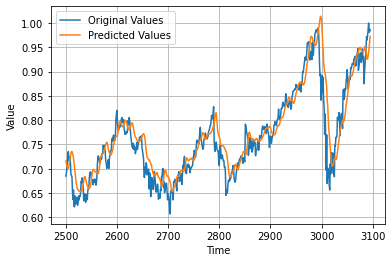

In [40]:
plot_series(time_valid, x_valid)
plot_series(time_valid,pd)
plt.legend(['Original Values','Predicted Values'])

In [41]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [42]:
print(rnn_forecast.shape)
print(x_valid.shape)
y=np.array(x_valid)
print(x_valid.shape)

(596,)
(596, 1)
(596, 1)


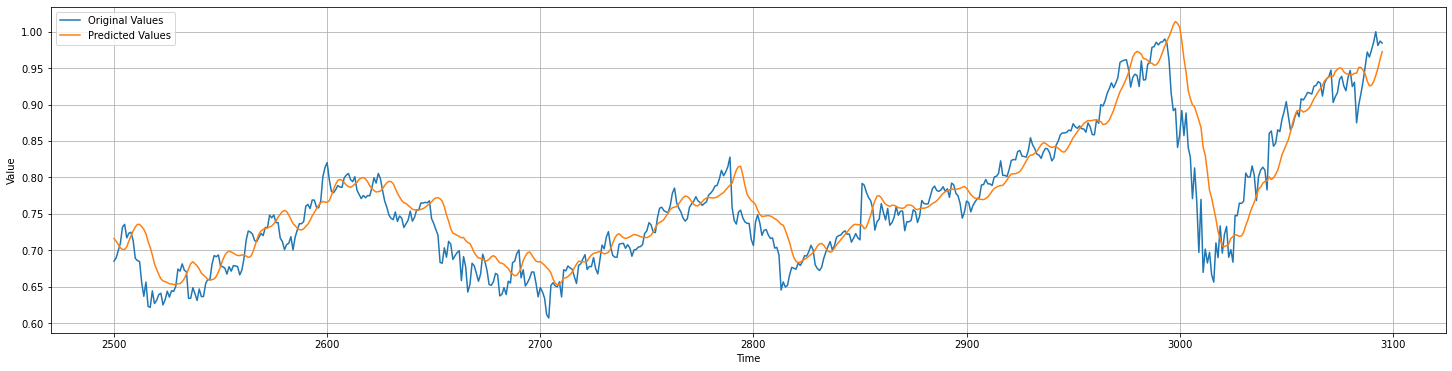

In [43]:
plt.figure(figsize=(25, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.legend(['Original Values','Predicted Values'])

In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

array([0.09205665, 0.08883036, 0.08229879, 0.07676658, 0.06805796,
       0.06715157, 0.07318887, 0.0707124 , 0.07029536, 0.07501261,
       0.08925723, 0.09149662, 0.09247249, 0.11800174, 0.13680543,
       0.11735768, 0.15071166, 0.15195975, 0.12929565, 0.14667661,
       0.14238644, 0.1345646 , 0.13248685, 0.14857718, 0.1413866 ,
       0.12974955, 0.13786209, 0.12918936, 0.13007568, 0.12294177,
       0.10105984, 0.10350334, 0.09505715, 0.10231391, 0.10447777,
       0.13957824, 0.13933004, 0.12492032, 0.13333064, 0.14245728,
       0.12673573, 0.13716005, 0.13698278, 0.11948341, 0.11372263,
       0.11430687, 0.09534897, 0.08655559, 0.08758169, 0.08601663,
       0.09775244, 0.09821466, 0.09990792, 0.1070957 , 0.09826244,
       0.1035526 , 0.09710714, 0.0974088 , 0.09822064, 0.10809685,
       0.10222143, 0.08929352, 0.07481664, 0.06972308, 0.07019676,
       0.07119142, 0.07501261, 0.07559873, 0.07287989, 0.07088383,
       0.07190849, 0.06820092, 0.06836782, 0.06493638, 0.06545

In [45]:
print(rnn_forecast)
print(x_valid)

[0.7159743  0.7123043  0.7076959  0.7031452  0.7010529  0.7008681
 0.704617   0.71263385 0.7198809  0.72639424 0.73175895 0.7354079
 0.7354187  0.73237175 0.72870374 0.72241724 0.7119489  0.70382047
 0.69339204 0.6811715  0.67401314 0.66666156 0.6608135  0.6576998
 0.65682065 0.6554651  0.6537928  0.6536457  0.6527392  0.6531695
 0.65401727 0.65391886 0.656915   0.660911   0.667369   0.67420554
 0.68156093 0.68402934 0.68121433 0.67855436 0.67411995 0.6684933
 0.6656185  0.6630576  0.65982956 0.6587628  0.6595506  0.66054004
 0.6639982  0.67021304 0.6773887  0.68621373 0.69286597 0.696799
 0.69877076 0.69737124 0.69608617 0.69405    0.6927276  0.6925811
 0.6934303  0.6932673  0.69188505 0.6901715  0.69091004 0.69614166
 0.70451    0.714227   0.72198427 0.7264243  0.72857076 0.7299961
 0.7304145  0.73198855 0.73315716 0.7362833  0.74028605 0.74521965
 0.7490766  0.7530918  0.7545783  0.75306875 0.7483827  0.74239045
 0.736449   0.73356164 0.7302166  0.72817606 0.7278315  0.72925603
 0.7

In [32]:
#Beyond Future Forecasting :